In [21]:
#!/usr/bin/env python

from __future__ import division, print_function

import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

import import_ipynb
#from snake_trainer_CNN import DQL_CNN
from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
is_done = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the gym environment
env = gym.make('Snake-8x8-v0')
env.reset()
env.seed(99)
PATH = './models/snakeaiCNN1.pkl'

model = torch.load(PATH)

#summary(model, (3, 8, 8))



/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [22]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(8, interpolation=Image.BOX),
                    T.ToTensor()])

def select_action(state):
    return model(state).max(1)[1].view(1, 1)

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    print(screen.shape)
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(np.around(screen, decimals=0))
    
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


/home/malthet/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3412, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 0.0314, 0.0000, 0.0000, 0.0000],
          

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


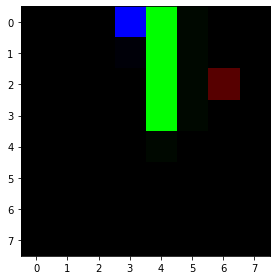

In [23]:
from skimage import io

last_screen = get_screen()
env.step(1)
current_screen = get_screen()
img = current_screen #+ last_screen
print(img)
io.imshow(img.squeeze(0).numpy().transpose(2, 1, 0))


In [24]:
num_episodes = 10

env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x % 1 == 0)

episode_reward = 0
rewards = []

for i_episode in range(num_episodes):

    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen + last_screen

    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_reward += reward

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen + last_screen
        else:
            next_state = None

        # Move to the next state
        state = next_state

        if done:
            rewards.append(episode_reward.item())
            #plot_durations()
            break


print('Complete')
#env.render()
env.close()
plt.plot(rewards)
plt.ioff()
plt.show()

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /home/malthet/deeplearning_ws/dl-project-grp21/src/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


TypeError: 'collections.OrderedDict' object is not callable